# **0. 루브릭**

| 평가문항 | 상세기준 |
|:----|:----|
| 1. tfrecord를 활용한 데이터셋 구성과 전처리를 통해 프로젝트 베이스라인 구성을 확인하였다. | MPII 데이터셋을 기반으로 1epoch에 30분 이내에 학습 가능한 베이스라인을 구축하였다. |
| 2. simplebaseline 모델을 정상적으로 구현하였다. | simplebaseline 모델을 구현하여 실습코드의 모델을 대체하여 정상적으로 학습이 진행되었다. |
| 3. Hourglass 모델과 simplebaseline 모델을 비교분석한 결과를 체계적으로 정리하였다. | 두 모델의 pose estimation 테스트결과 이미지 및 학습진행상황 등을 체계적으로 비교분석하였다. |

# **1. 실험하기**

## **1. 데이터 전처리하기**

앞으로 사용할 라이브러리를 불러옵니다.

고정해서 사용할 변수도 만들어 둡시다.

In [1]:
# 라이브러리 불러오기

# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있음
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# 데이터셋 경로 설정하기
PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

### **json 파싱하기**

이 파일들은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있어서 Pose Estimation을 위한 label로 삼을 수 있습니다.

우선 json이 어떻게 구성되어 있는지 파악해 보기 위해 json 파일을 열어 샘플로 annotation 정보를 1개만 출력해 봅시다.

In [3]:
# annotation 정보 확인하기
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


`joints` 가 우리가 label 로 사용할 keypoint 의 label 입니다. 이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에 `joints_vis` 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타냅니다.

`joints` 순서는 아래와 같은 순서로 배치되어 저장해 뒀습니다.

* 0 - 오른쪽 발목
* 1 - 오른쪽 무릎
* 2 - 오른쪽 엉덩이
* 3 - 왼쪽 엉덩이
* 4 - 왼쪽 무릎
* 5 - 왼쪽 발목
* 6 - 골반
* 7 - 가슴(흉부)
* 8 - 목
* 9 - 머리 위
* 10 - 오른쪽 손목
* 11 - 오른쪽 팔꿈치
* 12 - 오른쪽 어깨
* 13 - 왼쪽 어깨
* 14 - 왼쪽 팔꿈치
* 15 - 왼쪽 손목

`scale`과 `center`는 사람 몸의 크기와 중심점 입니다.`scale`은 200을 곱해야 온전한 크기가 됩니다.

이제 json annotation 을 파싱하는 함수를 만들어 봅시다.

In [4]:
# json annotation을 파싱하는 함수 구현하기
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

한 번 parse_one_annotation()함수를 테스트 해봅시다.

In [5]:
# parse_one_annotation()함수를 테스트하기
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


이제 우리가 원하는 정보만 뽑아낼 수 있게 되었습니다.

**Q. MPII 데이터셋에서 json 파일에서 'scale' 정보가 의미하는 바는 무엇인가요?**

MPII 데이터셋에서 'scale'은 사람의 크기 비율을 나타내는데, 관절의 위치 및 사람의 신체 부분 크기를 상대적으로 표현하는 데 사용됩니다.

일반적으로 관절의 좌표는 이미지의 크기에 따라 상대적으로 바뀌는 값이기 때문에 이를 보정하기 위해 scale 값을 제공하는 것이며, 이를 통해서 다른 크기의 이미지에서도 신체 부위의 위치를 일관성 있게 분석할 수 있습니다.

## **2. TFRecord 파일 만들기**

### **TFRecord 파일 만들기**

하지만 실제 프로젝트에서는 튜토리얼 데이터셋보다 훨씬 큰 크기의 데이터를 다뤄야 합니다.

일반적으로 학습 과정에서 gpu 의 연산 속도보다 HDD I/O 가 느리기 때문에 병목 현상이 발생하고 대단위 프로젝트 실험에서 효율성이 떨어지는 것을 관찰할 수 있습니다.

따라서 "학습 데이터를 어떻게 빠르게 읽는가?" 에 대한 고민을 반드시 수행하셔야 더 많은 실험을 할 수 있습니다.

Tensorflow에서는 위 변환을 자동화해주는 도구를 제공합니다. 데이터셋을 TFRecord 형태로 표현하는 것입니다.

TFRecord 는 binary record sequence 를 저장하기 위한 형식입니다.

내부적으로 `protocol buffer` 라는 것을 이용하는데, `protocol buffer` 는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리라고 생각하면 됩니다.

이제 구현을 시작하겠습니다.

앞서 추출한 annotation을 TFRecord로 변환하는 함수를 만들어 봅시다.

TFRecord 는 `tf.train.Example`들의 합으로 이루어지므로 하나의 annotation을 하나의 `tf.train.Example`로 만들어 주는 함수부터 작성합니다.

In [6]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

하나의 annotation이 `tf.train.Example`이 되었다면 이제 여러 annotation에 대해 작업할 수 있도록 함수를 만들어야 합니다.

그런데 여기서 하나의 TFRecord를 만들지 않고 여러 TFRecord를 만들어 볼 것입니다. 

우선 얼마나 많은 TFRecord를 만들지 결정할 함수를 만들어 봅시다.

In [7]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

데이터를 여러 그룹으로 나누는 sharding은 데이터 저장과 병렬 처리에 유리합니다. 전체 데이터를 n개의 그룹으로 나누어 n개의 TFRecord 파일을 생성합니다. 기업 단위의 큰 데이터를 여러 장비에 나누어 담는 것이 일반적입니다. 

적절한 파일 크기와 개수를 설정하는 것이 중요합니다. 너무 작은 파일로 많이 나누면 학습 중 잦은 입출력이 요구되고, 너무 큰 파일로 적게 나누면 입출력 시간이 길어져 GPU 계산 시간보다 입출력 시간이 더 걸릴 수 있습니다. 적절한 크기와 개수는 상황에 따라 다릅니다.

설명은 어렵지만 실행해보면 단순합니다. 그럼 `chunkify` 함수를 테스트 해봅시다.

In [8]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

0이 1000개 들어 있는 리스트가 64개로 쪼개졌습니다. 

`chunkify` 함수를 테스트 해봤으니 하나의 chunk를 TFRecord로 만들어 줄 함수를 만듭시다.

In [9]:
# 하나의 chunk를 TFRecord로 만들어 줄 함수 구현하기
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

`chunk` 안에는 여러 annotation들이 있고, annotation들은 `tf.train.Example`로 변환된 후에 문자열로 직렬화되어 TFRecord에 담깁니다.

또 한 가지 주의해서 봐야할 것은 함수 정의 위에 `@ray.remote`가 있다는 점입니다.

Ray는 병렬 처리를 위한 라이브러리인데, 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용할 수 있습니다.

이제 모든 준비가 되었으니 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수를 만듭시다.

In [10]:
# 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수 구현하기
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

함수는 모두 준비되었습니다. 이제 다음으로 넘어가 함수를 실행할 차례입니다.

## **3. Ray**

앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. 

train 데이터는 64개로, val 데이터는 8개의 파일로 만듭니다.

In [11]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2024-07-19 00:44:08,556	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.92gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

**Q. multiprocessing 과 ray 의 사용상 차이점은 무엇인가요? 위 링크를 참고해서 대답해 봅시다.**

**MP**는 병렬화를 위해 추상적 구조를 새로 설계해야 하지만 **ray**는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있는 장점이 있습니다.

## **4. data label 로 만들기**

지금까지 만든 함수들을 개별 함수로도 만들 수 있지만 객체 형태로 조합해 봅시다.

객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많습니다.

함수에서 객체의 메서드로 수정할 때는 `self`를 추가해야 하는 점을 잊지 맙시다.

In [12]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

(build_single_tfrecord pid=123) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords

이제 데이터 전처리가 완료되었으니 모델을 만들러 가봅시다.

## **5. 모델을 학습해보자**

### **Hourglass 모델 만들기**

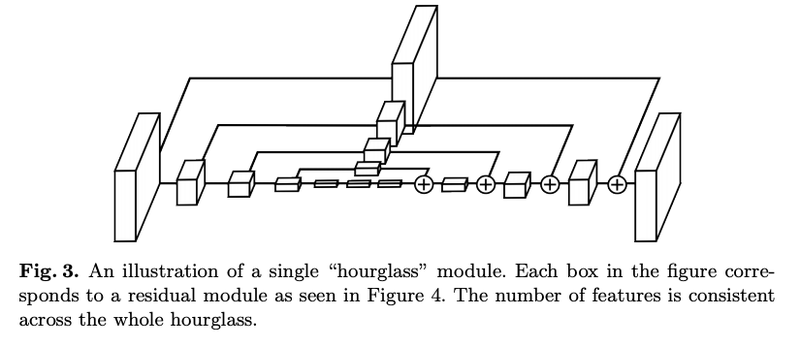

직육면체 박스는 residual block 이었습니다.

In [13]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

hourglass 모델을 잘 생각해 보면 마치 양파처럼 가장 바깥의 layer 를 제거하면 똑같은 구조가 나타나는 것을 알 수 있습니다.

재귀 함수를 이용해 HourglassModule 을 반복하면 order 가 1이 되면 BottleneckBlock 으로 대체해 주면 아주 간결하게 만들 수 있습니다.

In [14]:
# Hourglass 모듈 구현하기
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

> intermediate output을 위한 linear layer

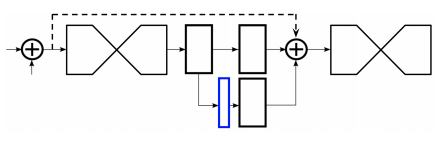

여러 모듈을 쌓을수록 모델이 깊어지는 만큼 학습이 어려워, **Intermediate supervision**을 적용하였습니다.

도식에서 보이는 모듈 사이의 네트워크의 파란 박스는 모델 중간에 계산되는 히트맵 결과를 출력하는 convolution layer입니다. 이 히트맵과 ground truth의 차이를 **intermediate loss (auxilary loss)**로 계산합니다.

In [15]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

따라서 stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산해 줍니다.

지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass 가 됩니다.

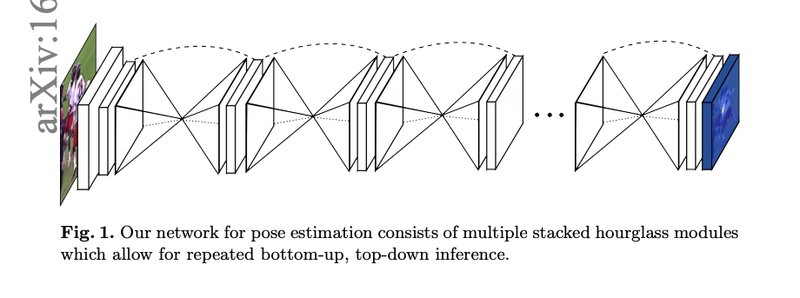

In [16]:
# StackedHourglassNetwork 함수 구현하기
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='Stacked_Hourglass')

In [17]:
# StackedHourglassNetwork 모델 생성하기
stacked_model = StackedHourglassNetwork()

In [18]:
# StackedHourglassNetwork 모델 요약하기
stacked_model.summary()

Model: "Stacked_Hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________

이제 `StackedHourglassNetwork`만 이용하면 모델을 쉽게 만들 수 있습니다.

### **Simplebaseline 구조**

* deconv module

In [19]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [20]:
upconv = _make_deconv_layer(3)

* 최종 레이어(final layer)

In [21]:
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

* Backbone : ResNet50

In [22]:
def SimpleBaseline(input_shape=(256, 256, 3)):
    # resnet backbone
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
                                                   
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)
    model = tf.keras.Model(inputs, out, name='Simple_Baseline')
    
    return model

이제 각각의 요소를 합쳐 모델을 완성합니다.

In [23]:
# Simple Baseline 모델 생성하기
simplebase_model = SimpleBaseline()

94781440/94765736 [==============================] - 1s 0us/step


In [24]:
# Simple Baseline 모델 요약하기
simplebase_model.summary()

Model: "Simple_Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


## **6. 학습 엔진 만들기**

### **GPU가 여러 개인 환경**

그런데 학습을 할 수 있는 GPU가 여러 개이고 데이터를 병렬로 학습시키려면 어떻게 해야할까요? 

여러 GPU를 사용하기 위해서는 약간의 코드를 추가해줘야 합니다.

가장 핵심 키워드는 `tf.distribute.MirroredStrategy`입니다. 

한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법입니다. 

여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합합니다. 

그런 후 모델의 가중치를 업데이트 하도록 하는 것입니다.

각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 `strategy.reduce` 함수가 담당합니다.

이번에도 각 함수를 별개로 만들지 않고 하나의 객체로 만들어 봅니다.

In [52]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        self.train_loss = []
        self.val_loss = []
        self.is_simple = True

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def comput_loss_simplebase(self, labels, outputs):
        loss = 0
        weights = tf.cast(labels > 0, dtype = tf.float32) * 81 + 1
        loss += tf.math.reduce_mean(tf.math.square(labels - outputs) * weights) *( 1./self.global_batch_size)
        
        return loss
    
    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            
            if self.is_simple:
                loss = self.comput_loss_simplebase(labels, outputs)
            else:
                loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        
        if self.is_simple:
                loss = self.comput_loss_simplebase(labels, outputs)
        else:
            loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        
        def distributed_train_epoch(dataset):
            tf.print('Start distributed training...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
        
        
        return self.best_model, self.train_loss, self.val_loss

    def save_model(self, epoch, loss):
        model_name = os.getenv('HOME') + '/mpii/weights' + '/shg_model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

**Q. tf.distribute.MirroredStrategy외에 Tensorflow의 GPU 분산 훈련을 위한 전략 메소드는 또 무엇이 있는지 알아볼까요?**

1. MirroredStrategy : TensorFlow에서 다중 GPU 환경에서 모델을 훈련하기 위한 분산 전략
2. TPUStrategy : 구글의 Tensor Processing Units(TPU)를 사용하여 모델을 훈련하기 위한 분산 전략
3. MultiWorkerMirroredStrategy : 다중 워커(worker) 환경에서 모델을 훈련하기 위한 분산 전략
4. ParameterServerStrategy : 다중 서버(server) 환경에서 모델을 훈련하기 위한 분산 전략
5. CentralStorageStrategy : 중앙 저장소를 사용하여 모델을 훈련하기 위한 분산 전략

이제 데이터셋을 만드는 함수를 작성합니다. 

TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러옵니다.

In [32]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

이제 데이터셋과 모델, 훈련용 객체를 조립만 하면 됩니다.

주의할 점은 `with strategy.scope():` 부분이 반드시 필요하다는 점입니다.

또한 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요합니다.

In [33]:
def stacked_hourglass_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        trainer
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [34]:
def simple_baseline_train(epochs, learning_rate,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join(weight_path)):
        os.makedirs(os.path.join(weight_path))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            )

        print('Start training...')
        trainer
        return trainer.run(train_dist_dataset, val_dist_dataset)

모델을 학습시킬 차례입니다. (1 Epoch 학습에만 1 시간 가까이 소요됩니다.)

In [35]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 10
batch_size = 8
num_heatmap = 16
learning_rate = 0.0007

In [53]:
# StackedHourglassNetwork 학습하기
stacked_model, train_loss, val_loss = stacked_hourglass_train(epochs, learning_rate, num_heatmap, 
                                                              batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed training...
Trained batch 1 batch loss 1.28931165 epoch total loss 1.28931165
Trained batch 2 batch loss 1.28962958 epoch total loss 1.28947067
Trained batch 3 batch loss 1.2438786 epoch total loss 1.27427328
Trained batch 4 batch loss 1.27144063 epoch total loss 1.27356517
Trained batch 5 batch loss 1.27479267 epoch total loss 1.27381063
Trained batch 6 batch loss 1.25460792 epoch total loss 1.27061021
Trained batch 7 batch loss 1.2231797 epoch total loss 1.26383436
Trained batch 8 batch loss 1.21406889 epoch total loss 1.25761366
Trained batch 9 batch loss 1.1712184 epoch total loss 1.24801421
Trained batch 10 batch loss 1.18406773 epoch total loss 1.24161959
Trained batch 11 batch loss 1.15298963 epoch total loss 1.23356235
Trained batch 12 batch loss 1.13507807 epoch total loss 1.22535527
Trained batch 13 batch loss 1.01909375 epoch total loss 1.20948899
Trained batch 14 batch loss 0.973246038 epoch total loss 1.19261456
Trained batch 15 batch loss 0.997541189 epo

In [38]:
# SimpleBaseline 학습하기
strategy = tf.distribute.MirroredStrategy()
global_batch_size = strategy.num_replicas_in_sync * batch_size

train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

# model checkpoint
model_checkpoint = os.getenv('HOME') + '/mpii/weights'+ '/simple_model-epoch-{epoch:02d}-loss-{val_loss:.4f}.h5'

model_cb = tf.keras.callbacks.ModelCheckpoint(filepath = model_checkpoint,
                                             save_weights_only = True,
                                             save_best_only = True,
                                             monitor = 'val_loss',
                                             )

# 모델 컴파일하기
simple_loss = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
simple_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

simplebase_model.compile(optimizer = simple_optimizer, loss = simple_loss)

# 모델 학습하기
simplebase_model.fit(train_dataset,
                          epochs = epochs,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          callbacks = [model_cb])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/10
2776/2776 [==============================] - 800s 285ms/step - loss: 0.0769 - val_loss: 0.0773
Epoch 2/10
2776/2776 [==============================] - 798s 287ms/step - loss: 0.0739 - val_loss: 0.0774
Epoch 3/10
2776/2776 [==============================] - 798s 287ms/step - loss: 0.0716 - val_loss: 0.0749
Epoch 4/10
2776/2776 [==============================] - 793s 285ms/step - loss: 0.0696 - val_loss: 0.0740
Epoch 5/10
2776/2776 [==============================] - 795s 286ms/step - loss: 0.0674 - val_loss: 0.0747
Epoch 6/10
2776/2776 [==============================] - 806s 290ms/step - loss: 0.0656 - val_loss: 0.0728
Epoch 7/10
2776/2776 [==============================] - 795s 286ms/step - loss: 0.0639 - val_loss: 0.0747
Epoch 8/10
2776/2776 [==============================] - 793s 285ms/step - loss: 0.0620 - val_loss: 0.0728
Epoch 9/10
2776/2776 [============================

## **7. 모델 평가하기**

### **예측 엔진 만들기**

In [41]:
WEIGHT_PATH = os.getenv('HOME') + '/mpii/weights'

In [54]:
# StackedHourglass 모델 가져오기
SHG_WEIGHTS_PATH = os.path.join(WEIGHT_PATH, 'shg_model-epoch-10-loss-0.5593.h5')

shg_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
shg_model.load_weights(SHG_WEIGHTS_PATH)

In [42]:
# SimpleBaseline 모델 가져오기
SBL_WEIGHTS_PATH = os.path.join(WEIGHT_PATH, 'simple_model-epoch-09-loss-0.0723.h5' )

sbl_model = SimpleBaseline(IMAGE_SHAPE)
sbl_model.load_weights(SBL_WEIGHTS_PATH)

이제 학습이 끝난 모델이 얼마나 잘 예측하는지 확인해 볼 시간입니다. 미리 학습된 모델을 불러옵시다.

학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정해 줍니다. 

변수에 저장되는 것은 해당 부위를 나타내는 인덱스입니다.

In [43]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

In [44]:
MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap입니다.

그래서 이 heatmap으로부터 좌표를 추출해야 합니다.

heatmap중에 최대값을 갖는 지점을 찾아내면 됩니다. heatmap에서 최대값을 찾는 함수를 만들어 줍니다.

In [45]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 

실제 계산에서는 3x3 필터를 이용해서 근사치를 구해줍니다.

In [46]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

이제 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수를 만들어 줍니다.

In [47]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

그림을 그릴 때는 두 가지 그림을 그려볼 겁니다. keypoint들과 뼈대입니다.

keypoint들은 관절 역할을 하고 keypoint들을 연결시킨 것이 뼈대가 되겠네요.

두 가지 함수를 각각 작성해 줍니다.

In [48]:
# keypoint(관절)을 그리는 함수 구현하기
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

In [49]:
# skeleton(뼈대)를 그리는 함수 구현하기
def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

이제 테스트 이미지를 이용해 모델의 성능을 확인해 봅시다.

In [50]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

* StackedHourglass 모델 결과 살펴보기

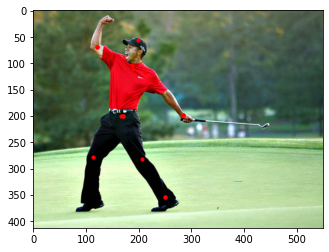

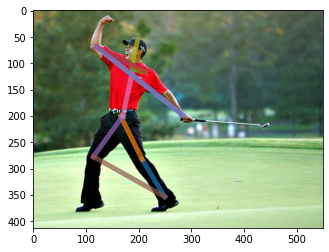

In [55]:
# StackedHourglass 모델 결과 살펴보기
SHG_image, SHG_keypoints = predict(shg_model, test_image)
draw_keypoints_on_image(SHG_image, SHG_keypoints)
draw_skeleton_on_image(SHG_image, SHG_keypoints)

* Simplebaseline 모델 결과 살펴보기

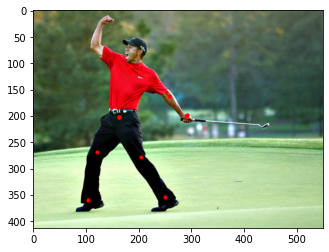

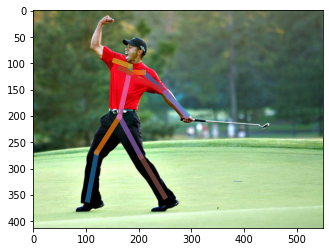

In [51]:
# Simplebaseline 모델 결과 살펴보기
SBL_image, SBL_keypoints = predict(sbl_model, test_image)
draw_keypoints_on_image(SBL_image, SBL_keypoints)
draw_skeleton_on_image(SBL_image, SBL_keypoints)

# **2. 회고**

**[배운 점 & 느낀 점]** FaceDetection도 재밌는 분야였는데, 사람의 포즈를 딥러닝으로 분석하고 표시한다는 것이 신기했다. 컴퓨터 비전이 특히 재밌는 것이, 코드에 대한 결과가 바로 바로 시각화할 수 있는 것인데, 이번 노드에서 그걸 더 깊이 경험해본 것 같다. 이후에는 영상도 같은 방식으로 시도해보고 싶다.

**[어려운 점 & 아쉬운 점]** 이번에는 모델 구현은 쉬웠지만, 학습을 저장하는 과정에서 SimpleBaseline 모델에서 계속 에러가 발생했다. 열심히 구글링을 한 결과, SimpleBaseline 모델은 기존대로 모델을 컴파일, 학습하는 것이 낫다는 결과를 얻고, 관련 방식으로 학습을 진행했다. 학습 저장 위치 경로 설정 과정에서도 해멨었는데, 결과적으로 적용이 잘되서 다행이다. 해멘 시간 때문에 다양한 사진으로 테스트를 진행해보지 못해서, StackedHourglass 모델과 SimpleBaseline 모델의 차이를 자세히 비교해 보지는 못했다. 그 점이 아쉬움으로 남는다.